<a href="https://colab.research.google.com/github/Srivardini11/lark/blob/main/Quarter9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install lightkurve --quiet

     |████████████████████████████████| 247 kB 22.9 MB/s 
     |████████████████████████████████| 98 kB 10.1 MB/s 
     |████████████████████████████████| 4.5 MB 59.0 MB/s 
     |████████████████████████████████| 41 kB 55 kB/s 
     |████████████████████████████████| 832 kB 50.8 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 3.6 MB 70.5 MB/s 


# **Import**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import lightkurve as lk
import numpy as np
from astropy.convolution import convolve, Box1DKernel
import seaborn as sb

matplotlib.rcParams['figure.figsize'] = (15,8)
sb.set_style('darkgrid')

# Code

To calculate the Kepler magnitude to correct the light flickers, I have downloaded the first 30,830 stars in the Quarter 9 period, whose Teff is in the range of 4500 to 6650 and their Kep Mag is greater than 12. The data is stored in a .csv format, so that we can use pandas to visualize the table clearly to do an exploratory analysis of the parameters.

In [21]:
df = pd.read_csv('kepler_quarter_9.csv')

In [23]:
df

,Kepler ID,Investigation ID,Dataset Name,Quarter,RA (J2000),Dec (J2000),Target Type,Archive Class,Ref,Actual Start Time,Actual End Time,Release Date,R Mag,J Mag,KEP Mag,2MASS ID,2MASS conflict flag,Teff,Log G,Metallicity,E(B-V),Radius,Total PM,G-R color,Module,Output,Channel,Skygroup_ID,Condition flag
0,757099,EX,KPLR000757099-2011177032512,9.0,19 24 10.337,+36 35 37.72,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.135,11.656,13.152,19241033+3635377,0.0,5589.0,3.817,-0.208,0.145,2.288,0.007,0.648,10.0,4.0,32.0,84.0,NaN
1,757450,EX,KPLR000757450-2011177032512,9.0,19 24 33.022,+36 34 38.57,LC,CLC,2.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,15.207,13.664,15.264,19243302+3634385,0.0,5101.0,4.480,-0.094,0.127,0.933,0.006,0.791,10.0,4.0,32.0,84.0,Exoplanet
2,891901,EX,KPLR000891901-2011177032512,9.0,19 23 49.243,+36 41 21.23,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.240,12.214,13.306,19234924+3641212,0.0,6051.0,4.411,-0.084,0.105,1.085,0.008,0.419,10.0,4.0,32.0,84.0,NaN
3,891916,EX,KPLR000891916-2011177032512,9.0,19 23 49.973,+36 41 11.80,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,14.761,13.516,14.799,19234997+3641118,0.0,5407.0,4.591,-0.580,0.114,0.834,0.010,0.585,10.0,4.0,32.0,84.0,NaN
4,892107,EX,KPLR000892107-2011177032512,9.0,19 24 00.250,+36 38 33.47,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-02-13 00:00:00,12.307,10.740,12.380,19240024+3638334,0.0,5029.0,3.355,-0.085,0.136,4.118,0.013,0.845,10.0,4.0,32.0,84.0,Red_giant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30825,5461988,EX,KPLR005461988-2011177032512,9.0,19 42 11.988,+40 38 56.51,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,15.180,13.762,15.223,19421198+4038564,0.0,5068.0,4.461,-0.376,0.129,0.953,0.006,0.735,15.0,2.0,50.0,78.0,NaN
30826,5462004,EX,KPLR005462004-2011177032512,9.0,19 42 13.346,+40 38 05.42,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.556,12.625,13.604,19421334+4038054,0.0,6004.0,4.682,-0.388,0.092,0.775,0.009,0.405,15.0,2.0,50.0,78.0,NaN
30827,5462007,EX,KPLR005462007-2011177032512,9.0,19 42 13.522,+40 36 45.22,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,15.576,14.394,15.630,19421352+4036452,0.0,5416.0,4.971,-0.228,0.109,0.514,0.014,0.608,15.0,2.0,50.0,78.0,NaN
30828,5462040,EX,KPLR005462040-2011177032512,9.0,19 42 15.415,+40 37 41.88,LC,CLC,0.0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.733,12.749,13.773,19421541+4037418,0.0,6033.0,4.514,-0.454,0.115,0.956,0.005,0.410,15.0,2.0,50.0,78.0,NaN


We can cross check if the data downloaded has the KEP Mag greater than 12 and Teff is in the required range. 

In [42]:
df['KEP Mag']

0        13.152
1        15.264
2        13.306
3        14.799
4        12.380
          ...  
30825    15.223
30826    13.604
30827    15.630
30828    13.773
30829       NaN
Name: KEP Mag, Length: 30830, dtype: float64

In [31]:
df['KEP Mag'].describe()

count    30829.000000
mean        14.588971
std          1.010686
min         12.001000
25%         13.830000
50%         14.815000
75%         15.406000
max         18.400000
Name: KEP Mag, dtype: float64

In [32]:
df['Teff'].describe()

count    30829.000000
mean      5551.755328
std        455.679953
min       4501.000000
25%       5239.000000
50%       5587.000000
75%       5869.000000
max       6650.000000
Name: Teff, dtype: float64

The data spread explains the abundancy of star distribution in each range 

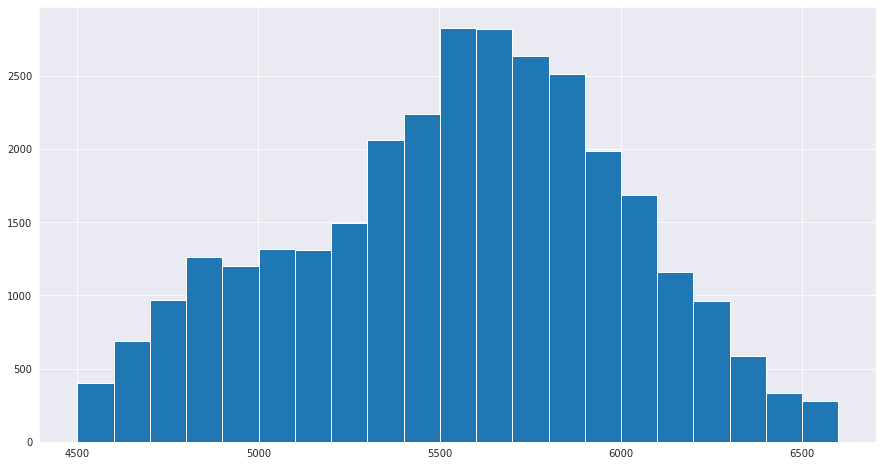

In [34]:
data = df['Teff']

min = data.min()
max = data.max()
step_size = 100
bins = np.arange(min,max, step_size)

plt.hist(data,bins);

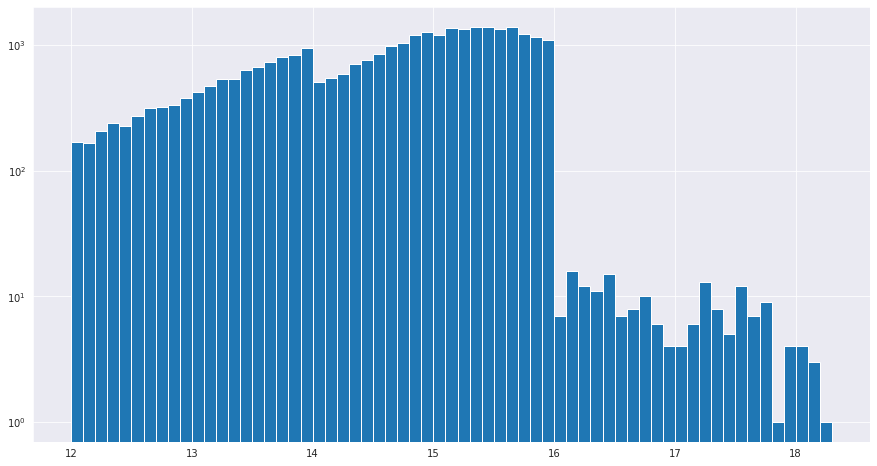

In [38]:
data = df['KEP Mag']

min = data.min()
max = data.max()
step_size = 0.1
bins = np.arange(min,max, step_size)
plt.hist(data,bins)
plt.yscale('log');

By polyfitting the graph of surface gravity and the flicker obtained by Boxcar fitting, we can obtain the Corrected F8. We test this for the first 500 stars as the basis.

In [14]:
df_test = df[:500]

In [17]:
flr_list = []
logg_list = []
for id in df_test['Dataset Name']:
  name    = id[:13]
  source  = lk.search_lightcurve(name, author="Kepler", cadence="long",quarter = 9).download()
  rem_out = source.remove_outliers(sigma_upper = 2.5).normalize()

  pg      = rem_out.to_periodogram(normalization='psd')
  seismo  = pg.flatten().to_seismology() 
  seismo.estimate_numax() 
  logg = seismo.estimate_logg()

  logg_list.append(logg.value)   


  index=50
  ind=250            
  flux    = rem_out.flux.value
  time    = rem_out.time.value
  smoothed_signal = convolve(flux, Box1DKernel(16))
  flkr    = flux[index:-ind]-smoothed_signal[index:-ind]
  flr     = np.sqrt(np.mean(flkr**2))*1e3

  flr_list.append(flr)

The 

In [ ]:
df

In [41]:
df_test['flicker']= flr_list
df_test['logg_lc'] = logg_list

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

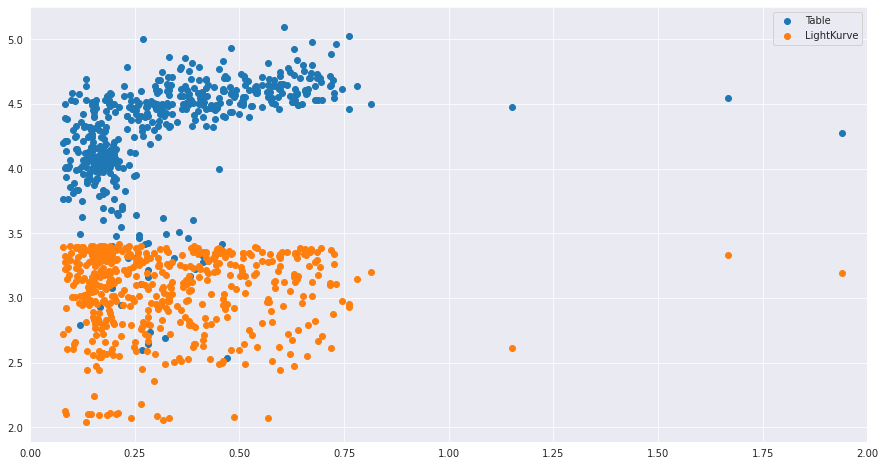

In [73]:
x = df_test['flicker']
y = df_test['Log G']

plt.scatter(x,y)
plt.xlim(0,2)

x = df_test['flicker']
y = df_test['logg_lc']

plt.scatter(x,y)
plt.xlim(0,2)
plt.legend(['Table','LightKurve'])

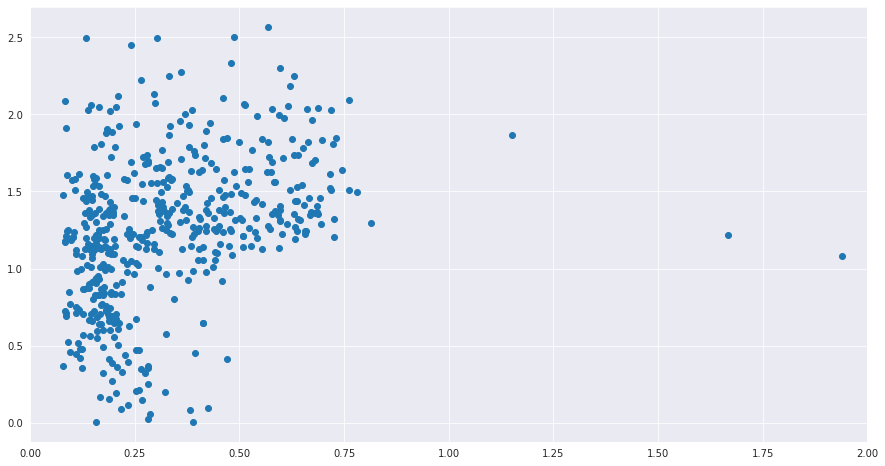

In [70]:
x = df_test['flicker']
y = abs(df_test['Log G'] - df_test['logg_lc'])

plt.scatter(x,y)
plt.xlim(0,2);

In [69]:
df_test = df_test.sort_values('flicker')

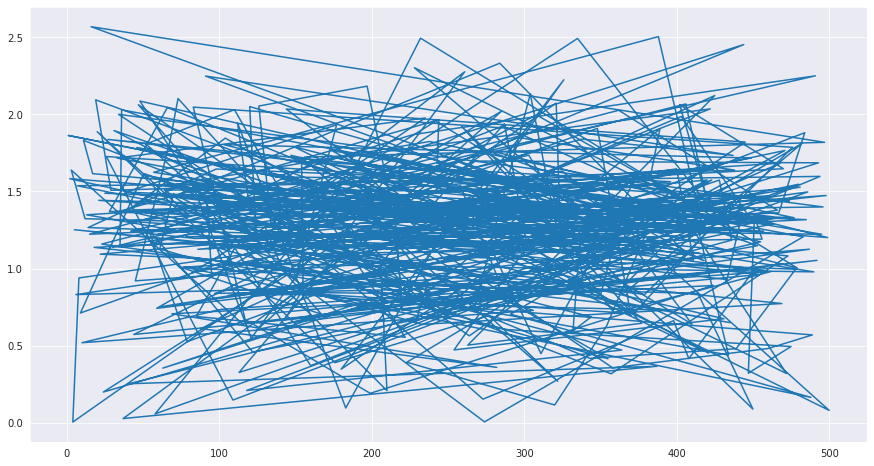

In [71]:
plt.plot(y)

In [68]:
df_test

,Kepler ID,Investigation ID,Dataset Name,Quarter,RA (J2000),Dec (J2000),Target Type,Archive Class,Ref,Actual Start Time,Actual End Time,Release Date,R Mag,J Mag,KEP Mag,2MASS ID,2MASS conflict flag,Teff,Log G,Metallicity,E(B-V),Radius,Total PM,G-R color,Module,Output,Channel,Skygroup_ID,Condition flag,flicker,logg_lc
1,757450,EX,KPLR000757450-2011177032512,9,19 24 33.022,+36 34 38.57,LC,CLC,2,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,15.207,13.664,15.264,19243302+3634385,0,5101.0,4.480,-0.094,0.127,0.933,0.006,0.791,10,4,32,84,Exoplanet,1.152110,2.616633
2,891901,EX,KPLR000891901-2011177032512,9,19 23 49.243,+36 41 21.23,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.240,12.214,13.306,19234924+3641212,0,6051.0,4.411,-0.084,0.105,1.085,0.008,0.419,10,4,32,84,NaN,0.152381,2.828280
3,891916,EX,KPLR000891916-2011177032512,9,19 23 49.973,+36 41 11.80,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,14.761,13.516,14.799,19234997+3641118,0,5407.0,4.591,-0.580,0.114,0.834,0.010,0.585,10,4,32,84,NaN,0.411129,2.952341
4,892107,EX,KPLR000892107-2011177032512,9,19 24 00.250,+36 38 33.47,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-02-13 00:00:00,12.307,10.740,12.380,19240024+3638334,0,5029.0,3.355,-0.085,0.136,4.118,0.013,0.845,10,4,32,84,Red_giant,0.157015,3.350937
5,892195,EX,KPLR000892195-2011177032512,9,19 24 05.206,+36 38 37.39,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.685,12.316,13.757,19240520+3638374,0,5553.0,3.972,-0.054,0.147,1.865,0.012,0.704,10,4,32,84,NaN,0.172969,2.720250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,1723529,EX,KPLR001723529-2011177032512,9,19 27 51.235,+37 15 50.87,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,14.996,13.590,15.079,19275123+3715508,0,4936.0,4.641,-0.060,0.093,0.738,0.002,0.798,10,4,32,84,NaN,0.369399,3.241441
497,1723618,EX,KPLR001723618-2011177032512,9,19 27 55.716,+37 15 41.47,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,15.636,14.471,15.679,19275571+3715414,0,5543.0,4.814,-0.166,0.133,0.638,0.000,0.596,10,4,32,84,NaN,0.569411,2.995309
498,1723638,EX,KPLR001723638-2011177032512,9,19 27 56.743,+37 15 19.66,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,14.624,13.435,14.699,19275674+3715196,0,5528.0,4.561,-0.039,0.120,0.877,0.000,0.598,10,4,32,84,NaN,0.364751,3.087238
499,1723671,EX,KPLR001723671-2011177032512,9,19 27 58.010,+37 14 44.74,LC,CLC,0,2011-03-21 00:24:25,2011-06-26 10:10:29,2012-07-28 12:00:00,13.502,12.550,13.551,19275800+3714447,0,6103.0,4.398,-0.195,0.119,1.105,0.004,0.414,10,4,32,84,NaN,0.152135,3.197249


In [64]:
table =[flr_list, logg_list, df_test['Log G']] 

In [66]:
pd.DataFrame({'Flicker':flr_list, 'Cal_Log':logg_list, 'Log G':df_test['Log G']})

,Flicker,Cal_Log,Log G
1,1.152110,2.616633,4.480
2,0.152381,2.828280,4.411
3,0.411129,2.952341,4.591
4,0.157015,3.350937,3.355
5,0.172969,2.720250,3.972
...,...,...,...
496,0.369399,3.241441,4.641
497,0.569411,2.995309,4.814
498,0.364751,3.087238,4.561
499,0.152135,3.197249,4.398
